## Load the data

In [33]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [34]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

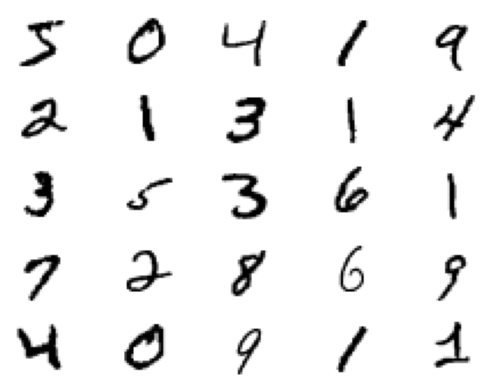

In [35]:
for i in range(25):
  plt.subplot(5, 5, 1 + i)
  plt.axis("off")
  plt.imshow(x_train[i], cmap='gray_r')
plt.show()

## Discriminator

In [36]:
d_input = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(64, (3, 3), 2, padding="same")(d_input)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Conv2D(64, (3, 3), 2, padding="same")(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Flatten()(x)
d_output = keras.layers.Dense(1, activation="sigmoid")(x)
discriminator = keras.Model(d_input, d_output)
discriminator.compile(loss="binary_crossentropy",
                      optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=["accuracy"])
discriminator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0   

In [37]:
def preprocess_data(x):
  x = np.expand_dims(x, axis=-1)
  x = x.astype('float32')
  x = x/255.0
  return x

In [38]:
x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [39]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  x = dataset[ix]
  y = np.ones((n_samples, 1))
  return x, y

In [40]:
def generate_fake_samples(n_samples):
  x = np.random.rand(28 * 28 * n_samples)
  x = x.reshape((n_samples, 28, 28, 1))
  y = np.zeros((n_samples, 1))
  return x, y

In [41]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch / 2)
  for i in range(n_iter):
    x_real, y_real = generate_real_samples(dataset, half_batch)
    _, real_acc = model.train_on_batch(x_real, y_real)
    x_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(x_fake, y_fake)
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [42]:
train_discriminator(model=discriminator, dataset=x_train)

>1 real=59% fake=9%
>2 real=70% fake=16%
>3 real=70% fake=30%
>4 real=74% fake=49%
>5 real=77% fake=70%
>6 real=80% fake=88%
>7 real=76% fake=85%
>8 real=77% fake=98%
>9 real=74% fake=97%
>10 real=72% fake=99%
>11 real=83% fake=100%
>12 real=72% fake=100%
>13 real=72% fake=100%
>14 real=82% fake=100%
>15 real=77% fake=100%
>16 real=76% fake=100%
>17 real=85% fake=100%
>18 real=84% fake=100%
>19 real=85% fake=100%
>20 real=86% fake=100%
>21 real=88% fake=100%
>22 real=88% fake=100%
>23 real=88% fake=100%
>24 real=94% fake=100%
>25 real=95% fake=100%
>26 real=96% fake=100%
>27 real=95% fake=100%
>28 real=98% fake=100%
>29 real=97% fake=100%
>30 real=97% fake=100%
>31 real=99% fake=100%
>32 real=98% fake=100%
>33 real=99% fake=100%
>34 real=100% fake=100%
>35 real=99% fake=100%
>36 real=100% fake=100%
>37 real=99% fake=100%
>38 real=99% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake=100%


##  Generator

In [43]:
latent_dim = 100

g_input = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(128 * 7 * 7)(g_input)
x = keras.layers.LeakyReLU(alpha=.2)(x)
x = keras.layers.Reshape((7, 7, 128))(x)
x = keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
g_output = keras.layers.Conv2D(1, (7, 7), activation="sigmoid", padding="same")(x)
generator = keras.Model(g_input, g_output)
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

## Latent Points

In [44]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

### Fake image generation with untrained generator

In [45]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  # Generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # Predict outputs
  x = g_model.predict(x_input)
  # Create 'fake' class labels (0)
  y = np.zeros((n_samples, 1))
  return x, y

1/1 [==============================] - 0s 153ms/step


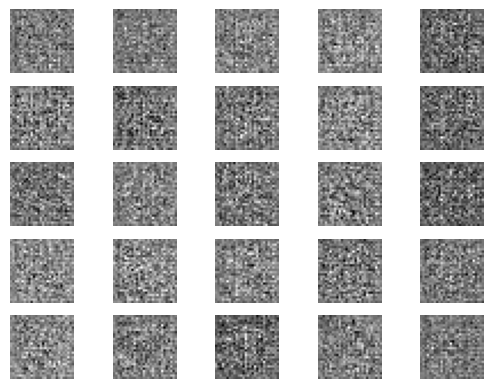

In [46]:
latent_dim = 100
n_samples = 25
x, _ = generate_fake_samples(generator, latent_dim, n_samples)
for i in range(n_samples):
  plt.subplot(5, 5, 1 + i)
  plt.axis("off")
  plt.imshow(x[i, :, :, 0], cmap='gray_r')
plt.show()

## Train the Generator

A new GAN model can be defined that stack the generator and discriminator such that the generator receives as input random points in the **latent space** and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to upadte the model weights of the generator.

The generator model is only concerned with the discriminator's performance on fake examples. Therefore, we will mark all of the layers in the discriminator as no trainable when it is part of the GAN model so that they cannot be ipadted and overtrained on fake examples.

When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class = 1). 

**Why would we want to do this?** We can imagine that the discriminator will then classify
the generated samples as not real (class = 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in
turn making the generator better at generating good fake samples.

* **Inputs:** Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
* **Outputs:** Binary classification, likelihood the sample is real (or fake).

In [53]:
discriminator.trainable = True

def define_gan(g_model, d_model):
  d_model.trainable = False
  model = keras.Sequential([
      g_model,
      d_model
  ])
  model.compile(loss="binary_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
  return model
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 28, 28, 1)         1164289   
                                                                 
 model_2 (Functional)        (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [54]:
discriminator.trainable = True

In [55]:
discriminator.predict(x_test[:10])

1/1 [==============================] - 0s 34ms/step


array([[0.9978605 ],
       [0.99885964],
       [0.9716011 ],
       [1.        ],
       [0.9994469 ],
       [0.9990258 ],
       [0.999406  ],
       [0.99927145],
       [0.9999931 ],
       [0.9999994 ]], dtype=float32)

## Evaluate GAN Model Performance

In [56]:
# create and save a plot of generated images (reversed grayscale) 
def save_plot(examples, epoch, n=10): 
  # plot images 
  for i in range(n * n): 
    # define subplot 
    plt.subplot(n, n, 1 + i) 
    # turn off axis 
    plt.axis("off") 
    # plot raw pixel data 
    plt.imshow(examples[i, :, :, 0], cmap="gray_r")
  # save plot to file 
  filename = "generated_plot_e%03d.png" % (epoch+1) 
  plt.savefig(filename)
  plt.close()

In [57]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  x_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch) 
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)

In [58]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  batch_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
      d_loss, _ = d_model.train_on_batch(x, y)
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, g_loss))
    if (i+1) % 10 == 0: 
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
dataset = x_train
train(generator, discriminator, gan_model, x_train, latent_dim)

4/4 [==============================] - 0s 4ms/step
>1, 1/234, d=0.012, g=4.306
4/4 [==============================] - 0s 4ms/step
>1, 2/234, d=0.012, g=4.343
4/4 [==============================] - 0s 5ms/step
>1, 3/234, d=0.010, g=4.298
4/4 [==============================] - 0s 4ms/step
>1, 4/234, d=0.010, g=4.324
4/4 [==============================] - 0s 4ms/step
>1, 5/234, d=0.009, g=4.379
4/4 [==============================] - 0s 4ms/step
>1, 6/234, d=0.010, g=4.374
4/4 [==============================] - 0s 3ms/step
>1, 7/234, d=0.012, g=4.400
4/4 [==============================] - 0s 4ms/step
>1, 8/234, d=0.012, g=4.378
4/4 [==============================] - 0s 4ms/step
>1, 9/234, d=0.014, g=4.389
4/4 [==============================] - 0s 4ms/step
>1, 10/234, d=0.009, g=4.415
4/4 [==============================] - 0s 3ms/step
>1, 11/234, d=0.012, g=4.397
4/4 [==============================] - 0s 3ms/step
>1, 12/234, d=0.013, g=4.395
4/4 [==============================] - 0s 4ms/ste